In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from sklearn.cluster import KMeans
from numpy import genfromtxt
import pandas as pd
import io
import matplotlib.pylab as pl
import ot
from scipy import linalg as la
from numpy.linalg import inv
import math
from scipy.spatial.distance import cdist
from haversine import haversine

In [115]:
#read in data
#df = pd.read_csv("IEMS CAD Data 2009 - 2016 (Times Added).csv")

#COMPARE PERFROMANCE WITH PRACTICE DATA
'''
df = pd.read_csv("indy_ems_overdose.csv")
df.dropna(inplace = True)
df = df.drop (['id', 'date'], axis = 1)
data = df.values
print (data)
'''

[[-86.154577  39.818899]
 [-86.156327  39.770164]
 [-86.185678  39.76759 ]
 ...
 [-86.111559  39.742415]
 [-86.126483  39.656481]
 [-86.123962  39.782244]]


1018169
940839


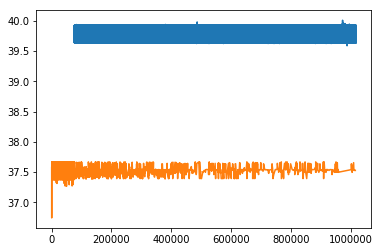

In [88]:
x = df.drop (['CALL_NO', 'UNIT_DISPATCH_DATE', 'Time of dispatch', 'CALL_TYPE_FINAL',
           'CALL_TYPE_FINAL_D', 'REP_DIST', 'LOCATION','Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 0'], axis = 1)
x1 = x[x.XCOORD > 38]
x2 = x[x.XCOORD <= 38]
print (len(x))
print (len(x1))
plt.plot(x1.XCOORD)
plt.plot(x2.XCOORD)

In [89]:
print (len(x1) / len(x))

0.9240499367000959


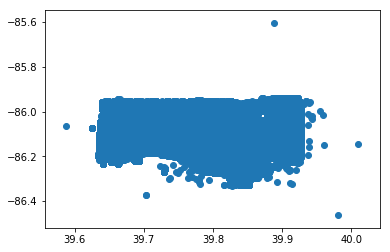

In [91]:
'''
data = np.zeros ((len (x), 2))
data [:, 0] = df.XCOORD
data [:, 1] = df.YCOORD
data = data [0:100, :]
'''
x1 = x1.dropna()
data = x1.values
plt.scatter(data[:,0], data[:,1])

In [116]:
print (np.amin((data[:,0])), np.amax((data[:,0])))
print (np.amin((data[:,1])), np.amax((data[:,1])))

-86.28778199999999 -85.94855
39.636982 39.925119


In [117]:
#idx = np.random.choice(np.arange(len(data)), size = 30)
#X = data [idx, :]
X1 = (np.amin((data[:,0])) - np.amax((data[:,0]))) * np.random.random_sample((30,1)) + np.amax((data[:,0]))
X2 = (np.amin((data[:,1])) - np.amax((data[:,1]))) * np.random.random_sample((30,1)) + np.amax((data[:,1]))

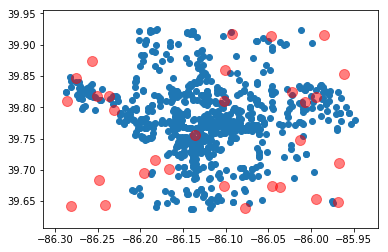

In [118]:
plt.scatter(data[:,0], data[:,1])
X = np.stack ((X1, X2), axis = 1)
X = X.reshape ((30,2))
plt.scatter(X[:, 0], X[:, 1], c = 'red', s = 100, alpha=0.5);

In [154]:
#function to implement the wasserstein algorithm
def wasserstein (M, lam, a, b, X):
    theta = 0.5
    while (1):
        K = math.e ** (-1 * lam * M)
        Kt = np.divide (K, a)
        u = np.transpose (np.ones(len(X)) / len(X))
        change = 1
        while (change > 0.0001):
            oldu = u
            p = np.matmul (np.transpose (K), u)
            f = np.divide (b, p)
            g = np.matmul (Kt, f)
            u = np.transpose (np.ones(len(X)) / g)
            change = la.norm (u - oldu)
        V = np.divide (b, np.matmul (np.transpose(K), u))        
        T = np.matmul (np.matmul (np.diag(u), K), np.diag (V))
        oldX = X
        X = (X * (1 - theta)) + (np.divide (np.matmul (T, data), a) * theta)  #(0.5 * np.matmul (np.matmul(np.diag(inv(a)), T), data))
        if (la.norm (oldX - X) < 0.0001):
            return X
       

In [155]:
#assign elements in data set D to clusters in X
def cluster_assignment (D, X):
    clusters = np.zeros ((len(D), 1))
    for i in range (len(D)):
        for j in range (len(X)):
            dist = la.norm (D [i,:] - X [j,:])
            if (j == 0 or dist < minDist):
                minDist = dist
                clusters [i] = j        
    D = np.hstack ((D, clusters))
    return D
                               
    

In [178]:
#attempt to use wasserstein
M = cdist(X, data, 'euclidean')
#b = np.ones ((30)) / 30
#a = np.ones ((100)) / 100
b = 30
a = len (data)
lam = 3500
test = wasserstein (M, lam, a, b, X)
fullData = cluster_assignment (data, test)

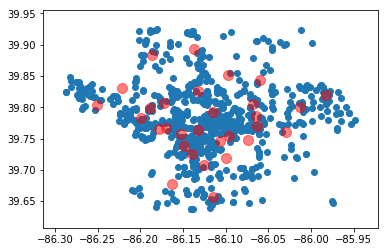

In [179]:
plt.scatter(data[:,0], data[:,1])
plt.scatter(test[:, 0], test[:, 1], c = 'red', s = 100, alpha=0.5);

In [126]:
kmeans = KMeans(n_clusters = 30, random_state = 0).fit(data)

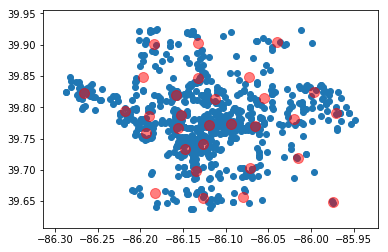

In [127]:
plt.scatter(data[:,0], data[:,1])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 100, alpha=0.5);

In [173]:
avg_dist = np.empty([0])
for i in range (30):
    dist_array = np.empty([0])
    for j in range (len(data)):
        if (kmeans.labels_ [j] == i):
            dist_array = np.append (dist_array, haversine (kmeans.cluster_centers_ [i], data [j], miles = True))
    avg_dist = np.append (avg_dist, dist_array.mean())
print (avg_dist.mean())

0.5966796885447982


In [180]:
#fullData = cluster_assignment (data, X)
fullData = cluster_assignment (data, test)
avg_dist = np.empty([0])
for i in range (30):
    dist_array = np.empty([0])
    for j in range (len(fullData)):
        if (fullData [j,2] == i):
            dist_array = np.append (dist_array, haversine (test [i], fullData [j, 0:2], miles = True))
    avg_dist = np.append (avg_dist, dist_array.mean())
print (avg_dist.mean())

0.8003685313994732


In [175]:
#Print out overage cluster size
avg_cluster = np.empty([0])
for i in range (30):
    x = 0
    for j in range (len(data)):
        if (kmeans.labels_ [j] == i):
            x += 1
    avg_cluster = np.append (avg_cluster, x)
print (avg_cluster)
print (avg_cluster.var())

[51. 31. 21. 21. 15. 22. 20. 28. 36. 37. 64. 24. 42. 11. 13. 31. 23. 17.
 34. 21. 10. 33.  7. 52. 51.  2.  9. 36. 26. 19.]
211.89000000000004


In [181]:
#Print out overage cluster size
avg_cluster = np.empty([0])
for i in range (30):
    x = 0
    for j in range (len(data)):
        if (fullData [j,2] == i):
            x += 1
    avg_cluster = np.append (avg_cluster, x)
print (avg_cluster)
print (avg_cluster.var())

[22. 18. 25. 13. 43. 27. 20. 21.  6. 11. 24. 26. 33. 36. 13. 35. 43. 24.
  7. 28. 37. 40. 22. 45. 31. 21. 28. 50. 21. 37.]
124.42333333333335


In [165]:
print (len(data))

807
